Open Play Shots - Expected Behind Model - Model Evaluation - GBM

In [38]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/")

In [39]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from expected_score_model.config import open_shots_file_path
from expected_score_model.domain.contracts.modelling_data_contract import ModellingDataContract
from expected_score_model.domain.modelling.supermodel import SuperXGBClassifier
from expected_score_model.domain.modelling.model_evaluation import XGBClassifierEvaluator

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


New Model

In [90]:
new_version = 5
model_name = "expected_behind_open"
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models"
preproc_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/preprocessors"

Comparison Model

In [91]:
old_version = new_version - 1
compare_train_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/train_predictions_"+model_name+"_v"+str(old_version)+".csv"
compare_test_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/test_predictions_"+model_name+"_v"+str(old_version)+".csv"

Response

In [92]:
RESPONSE = ModellingDataContract.RESPONSE_BEHIND

Features

In [93]:
FEATURES = ModellingDataContract.open_goal_modelling_feature_list

Load Data

In [94]:
df_modelling = pd.read_csv(open_shots_file_path)
df_modelling.tail()

Chain_Number Initial_State Final_State   Order  Quarter  \
9211           211        kickIn      behind  1705.0        4   
9212           212        kickIn        goal  1740.0        4   
9213           218      possGain        goal  1837.0        4   
9214           227       throwIn        goal  1901.0        4   
9215           233      possGain        goal  1971.0        4   

      Quarter_Duration_Chain_Start  Quarter_Duration Team_Chain     Team  \
9211                           744             775.0     Sydney   Sydney   
9212                           787             900.0    Geelong  Geelong   
9213                          1136            1198.0    Geelong  Geelong   
9214                          1452            1458.0    Geelong  Geelong   
9215                          1744            1753.0     Sydney   Sydney   

               Player AFL_API_Player_ID Description     x     y     Disposal  \
9211       Tom Papley        Tom_Papley        Kick  56.0 -36.0  ineffective   
9212  Brandan Parfitt   Brandan_Parfitt        Kick  75.0   0.0    effective   
9213    Sam De Koning     Sam_De_Koning        Kick  78.0   1.0    effective   
9214     Joel Selwood      Joel_Selwood        Kick  37.0  17.0    effective   
9215       Tom Papley        Tom_Papley        Kick  48.0 -20.0    effective   

      Shot_At_Goal  Behind_Detail  Venue_Width  Venue_Length Home_Team  \
9211          True            NaN          141           160   Geelong   
9212          True            NaN          141           160   Geelong   
9213          True            NaN          141           160   Geelong   
9214          True            NaN          141           160   Geelong   
9215          True            NaN          141           160   Geelong   

     Away_Team Home_Team_Direction_Q1               Match_ID Round_ID  Year  \
9211    Sydney                   left  2022F4_Geelong_Sydney   2022F4  2022   
9212    Sydney                   left  2022F4_Geelong_Sydney   2022F4  2022   
9213    Sydney                   left  2022F4_Geelong_Sydney   2022F4  2022   
9214    Sydney                   left  2022F4_Geelong_Sydney   2022F4  2022   
9215    Sydney                   left  2022F4_Geelong_Sydney   2022F4  2022   

      Goal  Behind  Miss  Score  Home_Score  Away_Score  Home_Current_Score  \
9211     0       1     0      1           0           1               107.0   
9212     1       0     0      6           6           0               113.0   
9213     1       0     0      6           6           0               119.0   
9214     1       0     0      6           6           0               125.0   
9215     1       0     0      6           0           6               137.0   

      Away_Current_Score  Current_Margin Event_Type0        Event_Type1  \
9211                32.0            75.0        Kick             Gather   
9212                33.0            80.0        Kick  Handball Received   
9213                39.0            80.0        Kick             Gather   
9214                45.0            80.0        Kick             Gather   
9215                45.0            92.0        Kick             Bounce   

            Event_Type2        Event_Type3    x0    x1    x2    x3    y0  \
9211               Kick  Handball Received  56.0  48.0   7.0   4.0 -36.0   
9212           Handball     Loose Ball Get  75.0  75.0  76.0  75.0   0.0   
9213               Kick  Handball Received  78.0  78.0  65.0  64.0   1.0   
9214           Knock On           Handball  37.0  37.0  43.0  34.0  17.0   
9215  Handball Received           Handball  48.0  38.0  35.0  37.0 -20.0   

        y1    y2    y3  Quarter_Duration0  Quarter_Duration1  \
9211 -44.0 -47.0 -37.0              775.0              771.0   
9212  -1.0  -5.0  -6.0              900.0              899.0   
9213   1.0 -12.0  -9.0             1198.0             1193.0   
9214  19.0  20.0  25.0             1458.0             1457.0   
9215 -31.0 -33.0 -37.0             1753.0             

In [95]:
df_modelling[['ballUp', 'centreBounce', 'kickIn', 'possGain', 'throwIn']] = pd.get_dummies(df_modelling['Initial_State'])

In [97]:
training_data = df_modelling[df_modelling[RESPONSE+"TrainingSet"]]
test_data = df_modelling[df_modelling[RESPONSE+"TestSet"]]
cal_data = df_modelling[df_modelling[RESPONSE+"ValidationSet"]]

In [98]:
X_train, y_train = training_data.drop(columns=[RESPONSE]), training_data[RESPONSE]
X_test, y_test = test_data.drop(columns=[RESPONSE]), test_data[RESPONSE]
X_cal, y_cal = cal_data.drop(columns=[RESPONSE]), cal_data[RESPONSE]

In [99]:
X_test.head()

Chain_Number Initial_State Final_State  Order  Quarter  \
5             43      possGain      behind  444.0        1   
6             46      possGain        goal  476.0        1   
8             79      possGain        goal  747.0        2   
9             83       throwIn        goal  781.0        2   
12            95      possGain        goal  888.0        2   

    Quarter_Duration_Chain_Start  Quarter_Duration      Team_Chain  \
5                           1272            1317.0  Brisbane Lions   
6                           1383            1389.0          Sydney   
8                            709             720.0          Sydney   
9                            848             861.0  Brisbane Lions   
12                          1285            1306.0  Brisbane Lions   

              Team           Player AFL_API_Player_ID Description     x     y  \
5   Brisbane Lions      Joe Daniher       Joe_Daniher        Kick  27.0  31.0   
6           Sydney     Isaac Heeney      Isaac_Heeney        Kick  56.0   6.0   
8           Sydney        Sam Wicks         Sam_Wicks        Kick  41.0  18.0   
9   Brisbane Lions     Jarryd Lyons      Jarryd_Lyons        Kick  46.0   2.0   
12  Brisbane Lions  Keidean Coleman   Keidean_Coleman        Kick  48.0   0.0   

       Disposal  Shot_At_Goal  Behind_Detail  Venue_Width  Venue_Length  \
5   ineffective          True            NaN          138           156   
6     effective          True            NaN          138           156   
8     effective          True            NaN          138           156   
9     effective          True            NaN          138           156   
12    effective          True            NaN          138           156   

         Home_Team Away_Team Home_Team_Direction_Q1  \
5   Brisbane Lions    Sydney                  right   
6   Brisbane Lions    Sydney                  right   
8   Brisbane Lions    Sydney                  right   
9   Brisbane Lions    Sydney                  right   
12  Brisbane Lions    Sydney                  right   

                       Match_ID Round_ID  Year  Goal  Miss  Score  Home_Score  \
5   202101_BrisbaneLions_Sydney   202101  2021     0     0      1           1   
6   202101_BrisbaneLions_Sydney   202101  2021     1     0      6           0   
8   202101_BrisbaneLions_Sydney   202101  2021     1     0      6           0   
9   202101_BrisbaneLions_Sydney   202101  2021     1     0      6           6   
12  202101_BrisbaneLions_Sydney   202101  2021     1     0      6           6   

    Away_Score  Home_Current_Score  Away_Current_Score  Current_Margin  \
5            0                18.0                 9.0             9.0   
6            6                19.0                 9.0            10.0   
8            6                20.0                40.0           -20.0   
9            0                20.0                46.0           -26.0   
12           0                32.0                46.0           -14.0   

   Event_Type0           Event_Type1            Event_Type2  \
5         Kick     Handball Received               Handball   
6         Kick     Handball Received               Handball   
8         Kick     Handball Received               Handball   
9         Kick                Gather               Knock On   
12        Kick  Loose Ball Get Crumb  Kick Inside 50 Result   

          Event_Type3    x0    x1    x2    x3    y0    y1    y2    y3  \
5            Free For  27.0  28.0  34.0  35.0  31.0  34.0  35.0  34.0   
6   Handball Received  56.0  58.0  58.0  58.0   6.0  21.0  25.0  26.0   
8   Handball Received  41.0  38.0  37.0  36.0  18.0  16.0  15.0  15.0   
9            Handball  46.0  41.0  35.0  30.0   2.0   2.0  -1.0  -2.0   
12      Kick Into F50  48.0  45.0  51.0  31.0   0.0  -5.0  -8.0 -43.0   

    Quarter_Duration0  Quarter_Duration1  Quarter_Duration2  \
5              1317.0             1316.0             1314.0   
6              1389.0             1389.0             1388.0   
8 

Preprocess Data

In [100]:
# preprocessor = DataPreprocessor()
# preprocessor.fit(X_train)

# X_train_preproc = preprocessor.transform(X_train)
# X_test_preproc = preprocessor.transform(X_test)

In [101]:
X_train_preproc = X_train[FEATURES]
X_test_preproc = X_test[FEATURES]

In [102]:
X_train_preproc.shape, X_test_preproc.shape

((5897, 17), (1844, 17))

In [103]:
X_train_preproc.head()

x0    x1    x2    x3  Distance_Since_Last_Action  \
0  26.0  18.0  11.0   6.0                    8.246211   
1  35.0  28.0  25.0  22.0                    7.000000   
3  34.0  19.0  10.0   7.0                   15.132746   
4  40.0  36.0  34.0  32.0                    4.123106   
7  65.0  62.0  60.0  60.0                    3.162278   

   Distance_to_Middle_Goal  Angle_to_Middle_Goal  Visible_Goal_Angle  ballUp  \
0                56.080300              0.383818            0.106164       0   
1                47.010637              0.416065            0.125105       0   
3                46.486557              0.328553            0.130930       0   
4                39.560081              0.281772            0.156423       0   
7                19.849433              0.856706            0.216802       0   

   centreBounce  kickIn  possGain  throwIn  Distance_to_Right_Goal_x  \
0             1       0         0        0                      52.0   
1             0       0         1        0                      43.0   
3             0       0         1        0                      44.0   
4             0       0         1        0                      38.0   
7             0       0         1        0                      13.0   

   Distance_to_Middle_y  Chain_Duration  Time_Since_Last_Action  
0                  21.0            26.0                     1.0  
1                  19.0            19.0                     1.0  
3                  15.0            13.0                     2.0  
4                  11.0             5.0                     3.0  
7                  15.0            38.0                     1.0

In [104]:
X_test_preproc.head()

x0    x1    x2    x3  Distance_Since_Last_Action  \
5   27.0  28.0  34.0  35.0                    3.162278   
6   56.0  58.0  58.0  58.0                   15.132746   
8   41.0  38.0  37.0  36.0                    3.605551   
9   46.0  41.0  35.0  30.0                    5.000000   
12  48.0  45.0  51.0  31.0                    5.830952   

    Distance_to_Middle_Goal  Angle_to_Middle_Goal  Visible_Goal_Angle  ballUp  \
5                 59.682493              0.546167            0.091898       0   
6                 22.803509              0.266252            0.276208       0   
8                 41.146081              0.452778            0.140721       0   
9                 32.062439              0.062419            0.201226       0   
12                30.000000              0.000000            0.215789       0   

    centreBounce  kickIn  possGain  throwIn  Distance_to_Right_Goal_x  \
5              0       0         1        0                      51.0   
6              0       0         1        0                      22.0   
8              0       0         1        0                      37.0   
9              0       0         0        1                      32.0   
12             0       0         1        0                      30.0   

    Distance_to_Middle_y  Chain_Duration  Time_Since_Last_Action  
5                   31.0            45.0                     1.0  
6                    6.0             6.0                     0.0  
8                   18.0            11.0                     0.0  
9                    2.0            13.0                     0.0  
12                   0.0            21.0                     1.0

Load Model

In [107]:
super_xgb = joblib.load(model_file_path + "/" + model_name + "_v" + str(new_version) + ".joblib")

In [108]:
super_xgb.xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.636601947872166, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.08875401321523607, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.45194...
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=99, missing=nan,
              monotone_constraints={'Angle_to_Middle_Goal': -1,
                                    'Distance_Since_Last_Action': 1,
                                    'Distance_to_Middle_Goal': -1,
                                    'Visible_Goal_Angle': 1, 'x0': -1},
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Get Predictions

In [109]:
train_preds = super_xgb.predict(X_train_preproc)
test_preds = super_xgb.predict(X_test_preproc)

In [110]:
train_probas = super_xgb.predict_proba(X_train_preproc)[:, 1]
test_probas = super_xgb.predict_proba(X_test_preproc)[:, 1]

In [111]:
train_cal_probas = super_xgb.predict_proba(X_train_preproc, calibrate=True)
test_cal_probas = super_xgb.predict_proba(X_test_preproc, calibrate=True)

Compare Model

In [112]:
compare_train_data = pd.read_csv(compare_train_predictions_file_path)
compare_test_data = pd.read_csv(compare_test_predictions_file_path)

In [113]:
compare_train_data = compare_train_data.rename(columns = {'xgb_preds':'old_preds',
                                                          'xgb_probas':'old_probas'})
compare_test_data = compare_test_data.rename(columns = {'xgb_preds':'old_preds',
                                                        'xgb_probas':'old_probas'})

In [114]:
training_data.shape, compare_train_data.shape

((5897, 79), (7208, 23))

In [115]:
training_data = pd.merge(training_data, compare_train_data[["Match_ID", "Chain_Number", "Order", 'old_preds', 'old_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])
test_data = pd.merge(test_data, compare_test_data[["Match_ID", "Chain_Number", 'Order', 'old_preds', 'old_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])

Evaluate Model

In [116]:
training_data['xgb_preds'] = train_preds
training_data['xgb_probas'] = train_probas
training_data['xgb_cal_probas'] = train_cal_probas

train_xgb_evals = XGBClassifierEvaluator(model = super_xgb.xgb_model,
                                       data = training_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_cal_probas",
                                       expected_label_name = "xgb_preds",
                                       compare_name='xgb_probas',
                                       compare_label_name="xgb_preds"
                                       )

In [117]:
test_data['xgb_preds'] = test_preds
test_data['xgb_probas'] = test_probas
test_data['xgb_cal_probas'] = test_cal_probas

test_xgb_evals = XGBClassifierEvaluator(model = super_xgb.xgb_model,
                                       data = test_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_cal_probas",
                                       expected_label_name = "xgb_preds",
                                       compare_name = "xgb_probas",
                                       compare_label_name="xgb_preds"
                                       )

Model Averages

In [118]:
training_data[[RESPONSE, 'xgb_probas', 'xgb_cal_probas', 'old_probas']].describe()

Behind   xgb_probas  xgb_cal_probas   old_probas
count  5897.000000  5897.000000     5897.000000  4600.000000
mean      0.364762     0.368555        0.368573     0.375235
std       0.481404     0.094935        0.081718     0.093844
min       0.000000     0.115579        0.120109     0.091783
25%       0.000000     0.314733        0.329352     0.323178
50%       0.000000     0.381484        0.385730     0.381084
75%       1.000000     0.433913        0.425381     0.436197
max       1.000000     0.601741        0.529259     0.689140

In [119]:
test_data[[RESPONSE, 'xgb_probas', 'xgb_cal_probas', 'old_probas']].describe()

Behind   xgb_probas  xgb_cal_probas  old_probas
count  1844.000000  1844.000000     1844.000000  393.000000
mean      0.364967     0.364393        0.364987    0.374212
std       0.481552     0.096080        0.083505    0.099886
min       0.000000     0.117271        0.122086    0.091783
25%       0.000000     0.310202        0.325271    0.320998
50%       0.000000     0.376052        0.381396    0.380152
75%       1.000000     0.433097        0.424793    0.441780
max       1.000000     0.606151        0.531583    0.602198

Plots

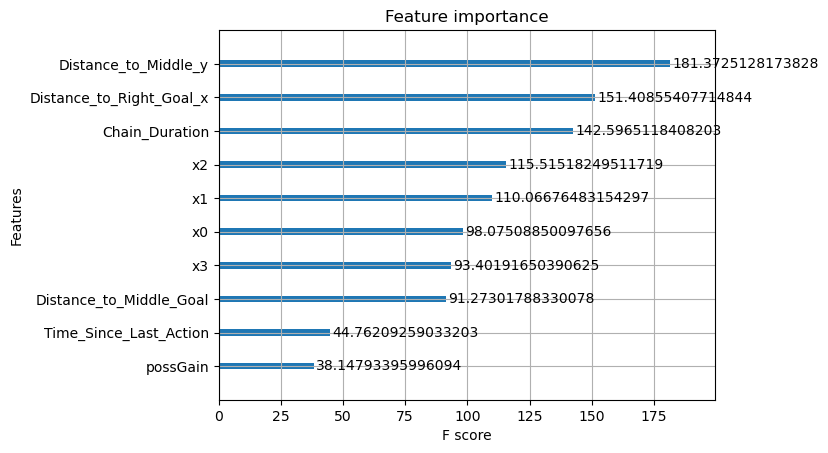

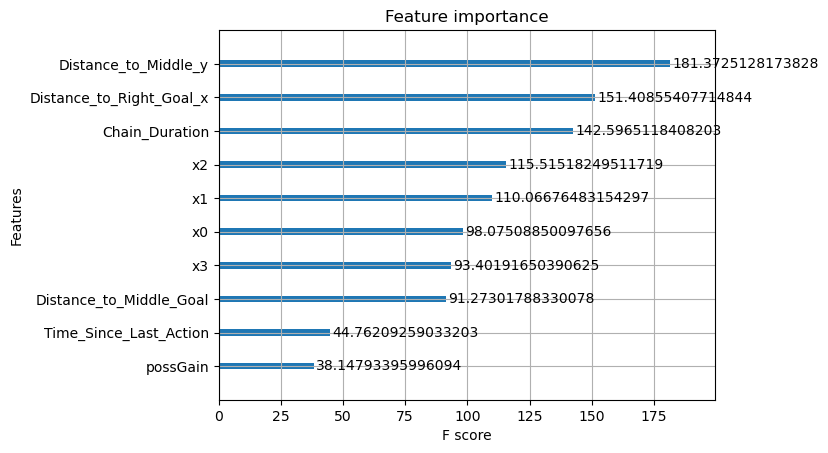

In [121]:
train_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")
test_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

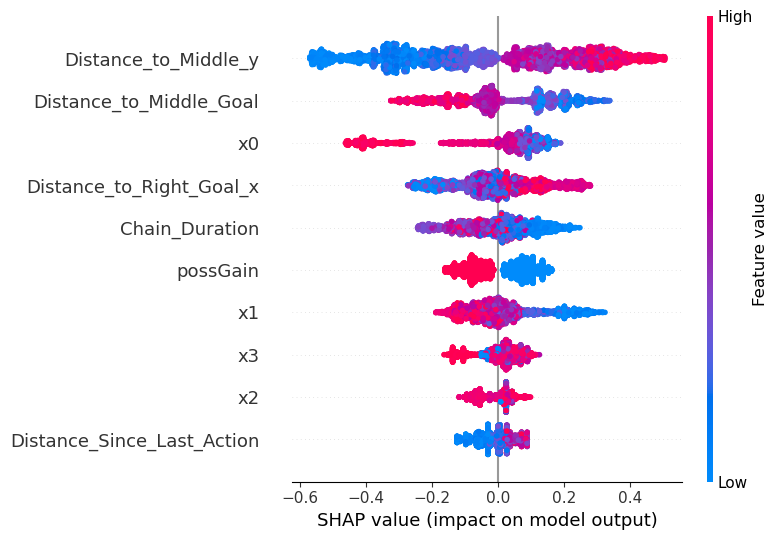

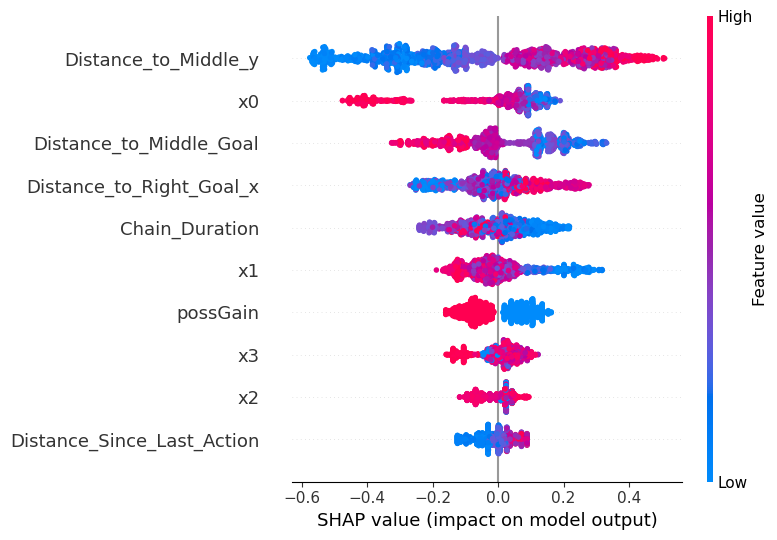

In [122]:
train_xgb_evals.plot_shap_summary_plot()
test_xgb_evals.plot_shap_summary_plot()

In [123]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['Distance_to_Middle_y',
 'x0',
 'Distance_to_Middle_Goal',
 'Distance_to_Right_Goal_x',
 'Chain_Duration',
 'x1',
 'possGain',
 'x3',
 'x2',
 'Distance_Since_Last_Action']

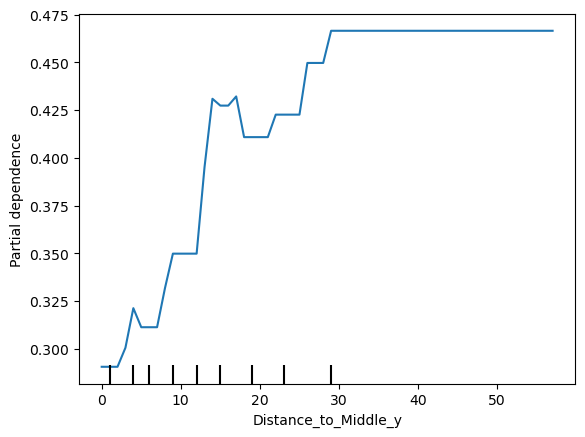

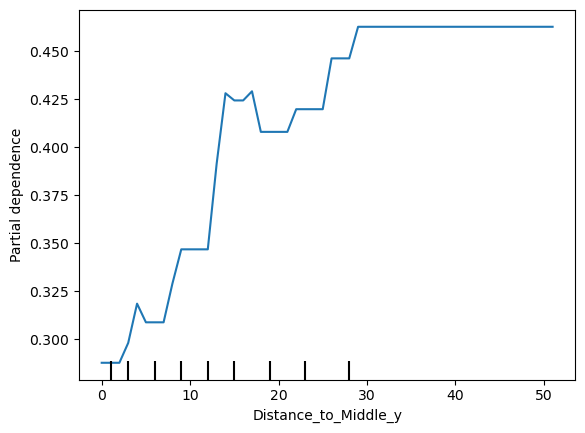

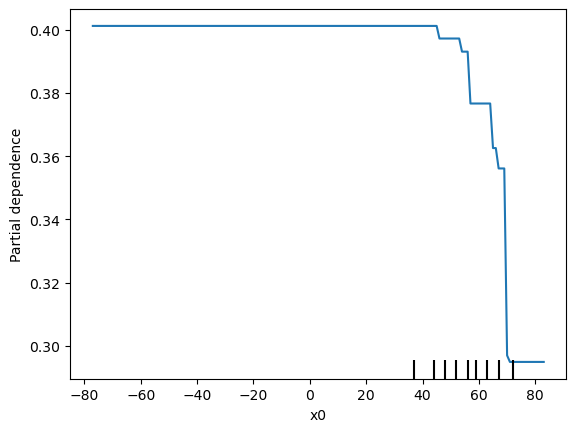

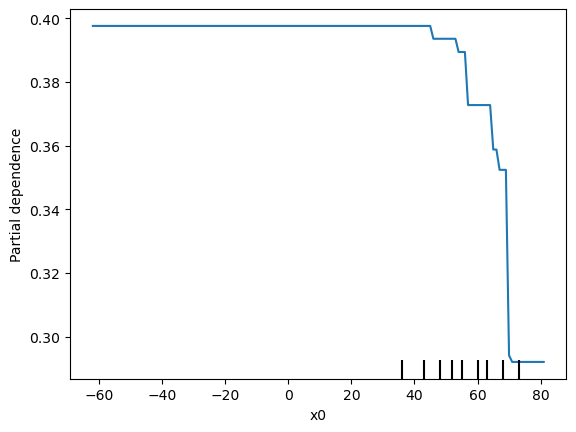

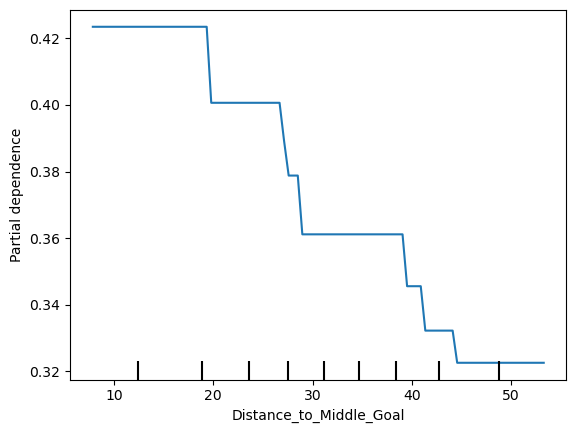

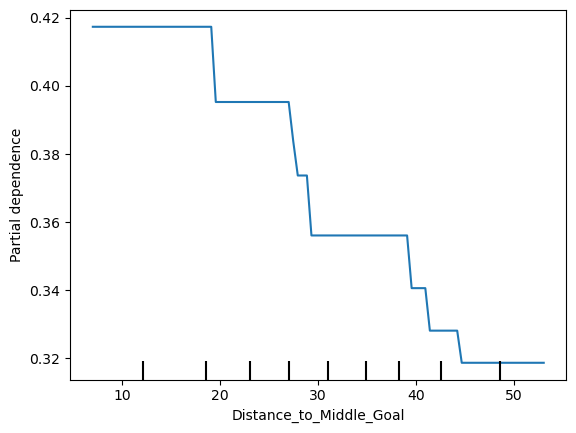

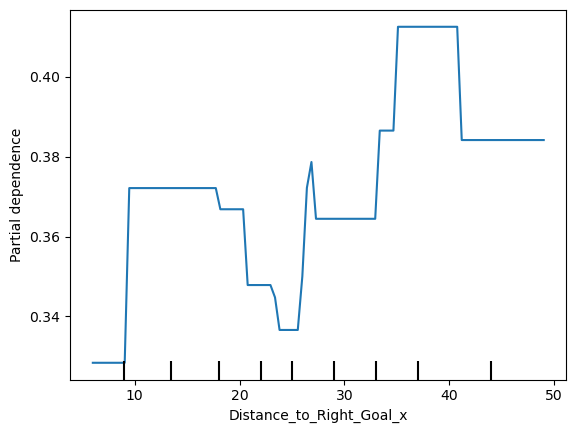

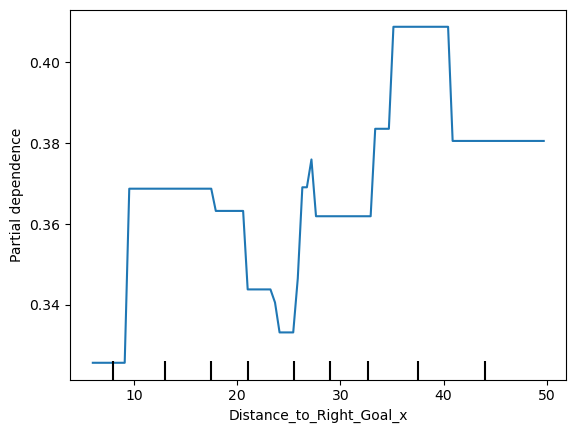

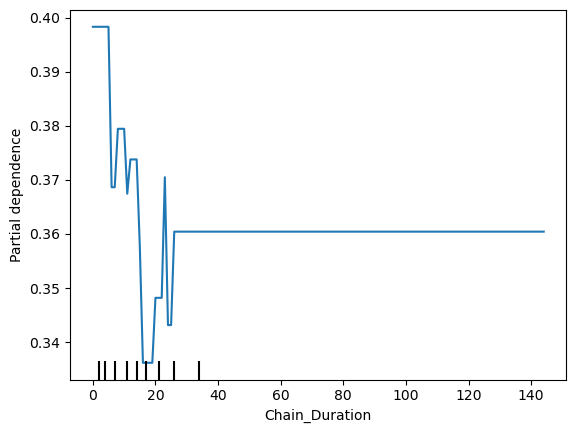

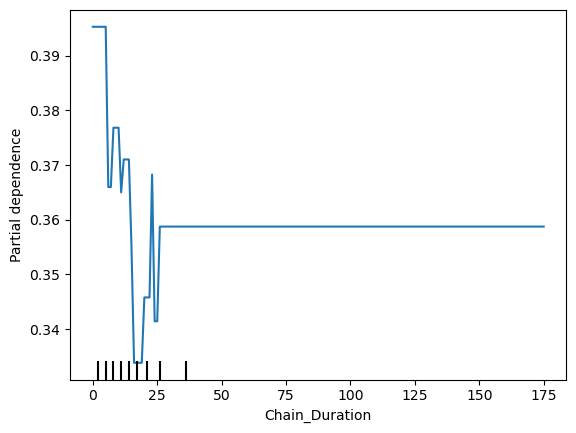

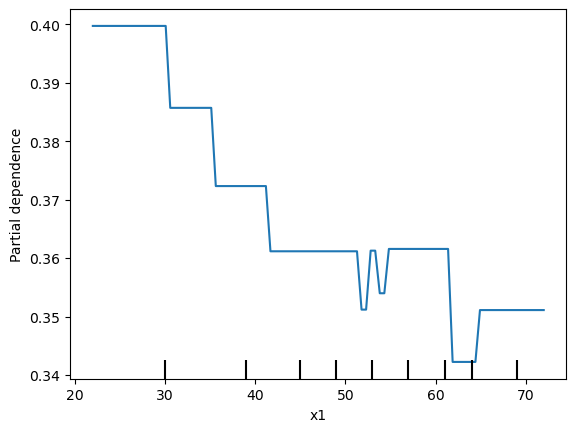

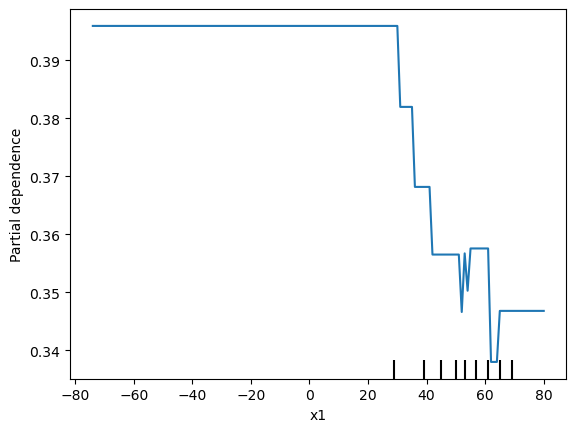

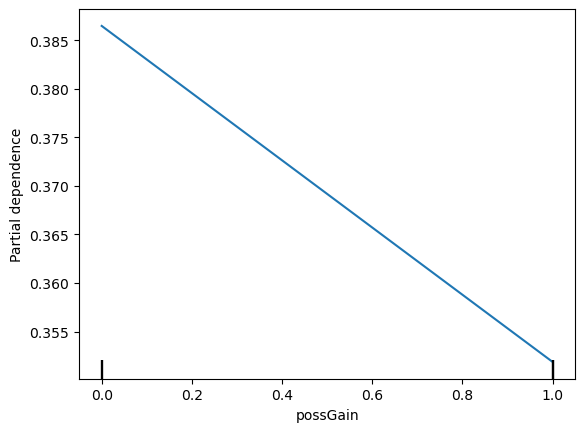

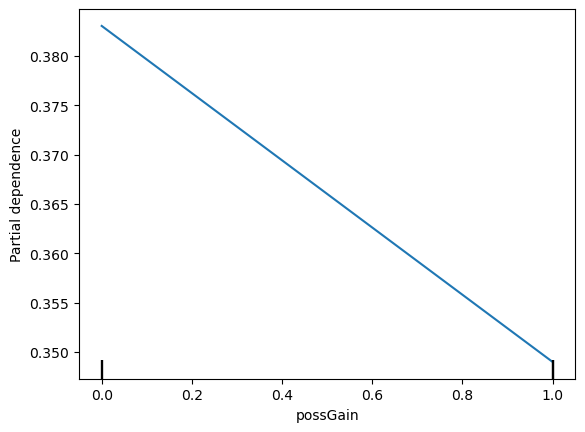

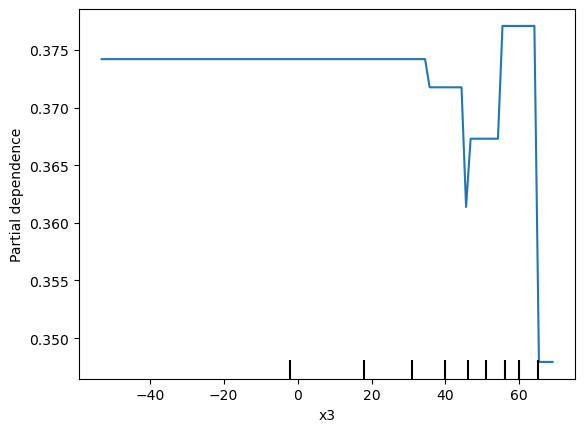

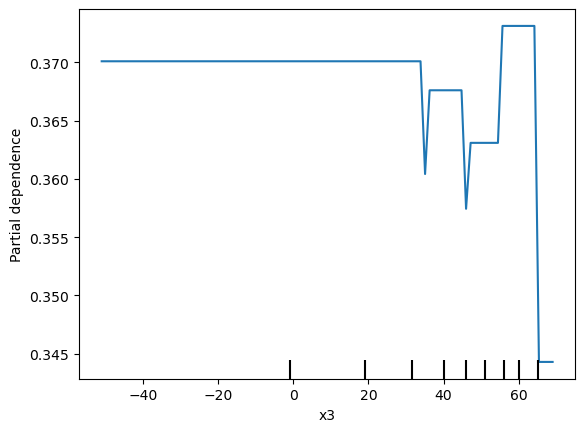

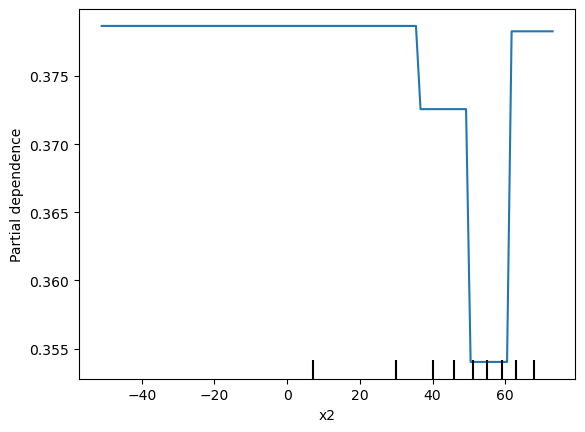

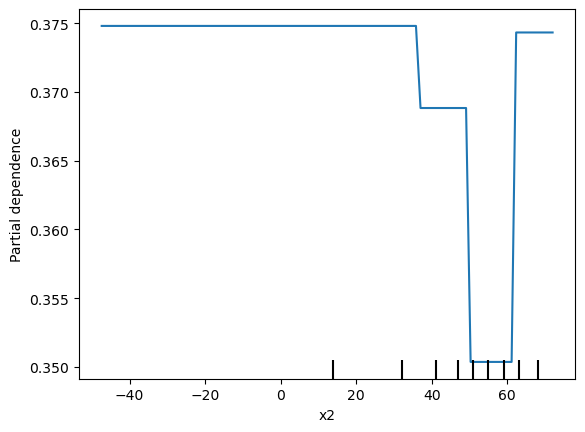

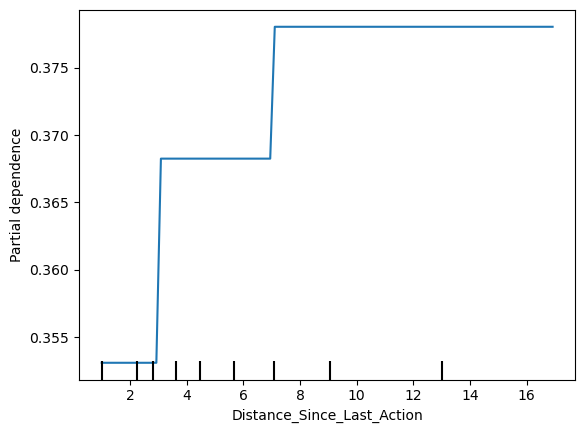

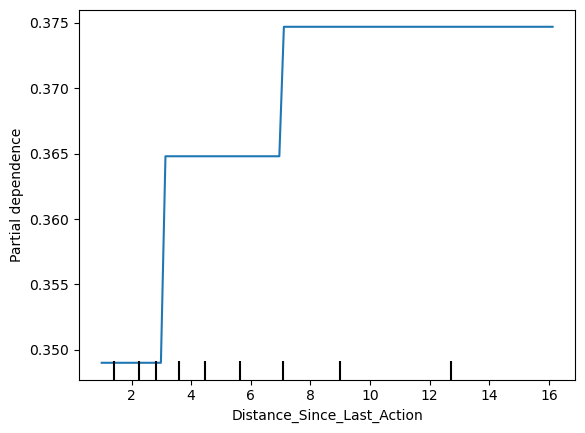

In [124]:
for col in top_10_features:
    train_xgb_evals.plot_pdp([col])
    test_xgb_evals.plot_pdp([col])

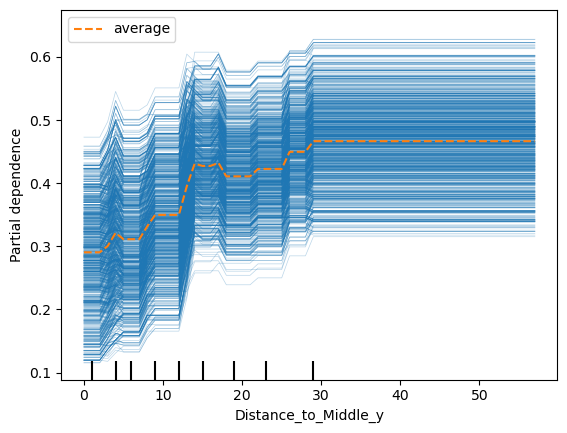

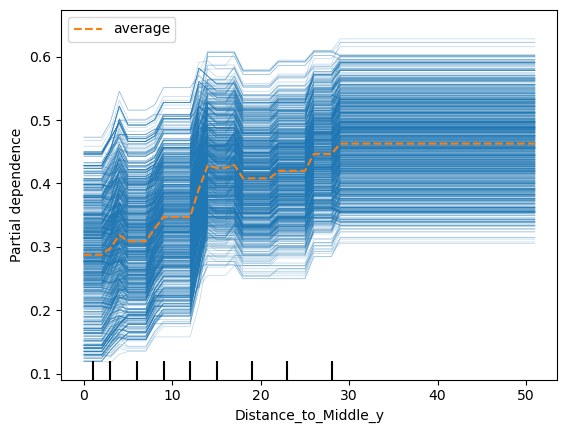

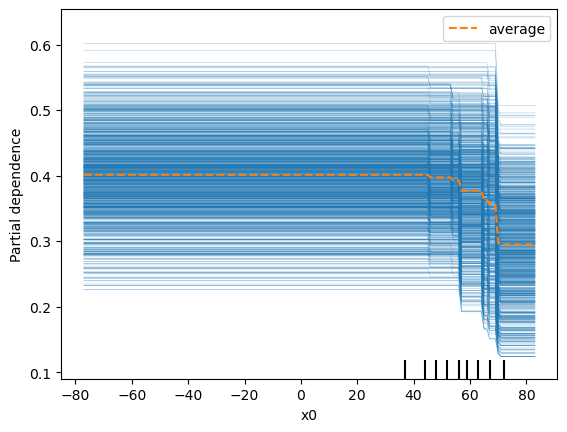

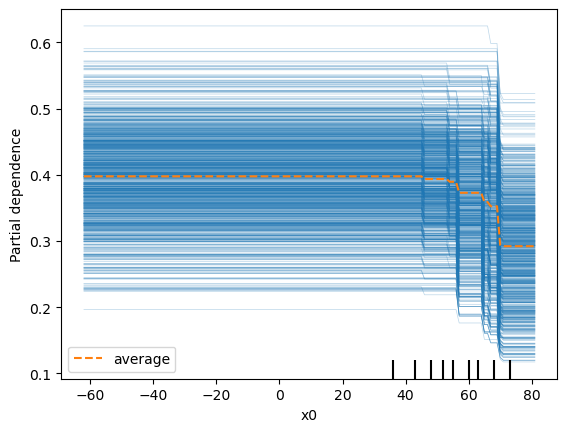

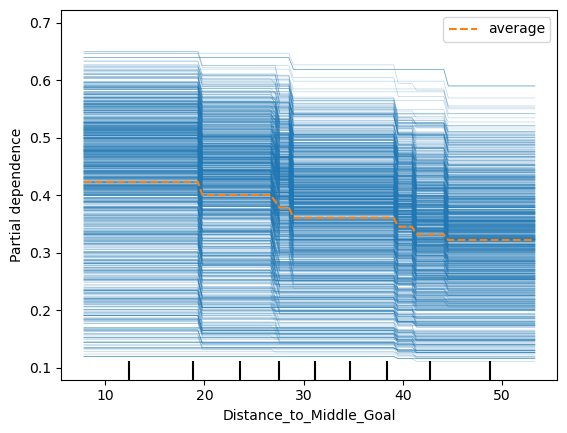

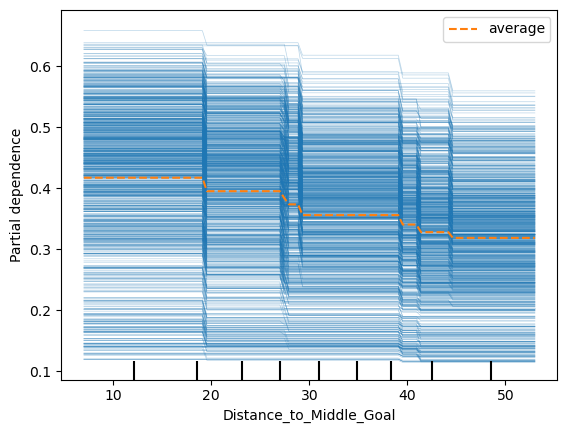

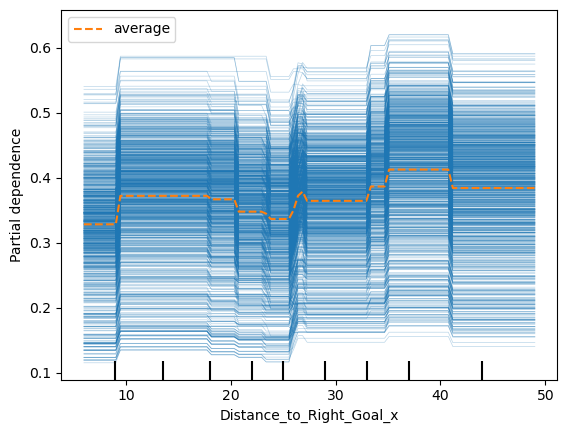

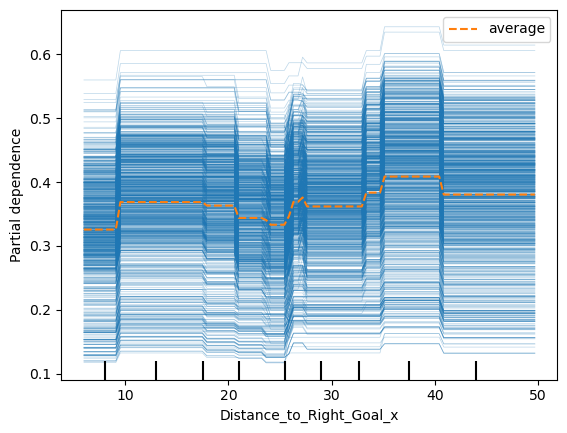

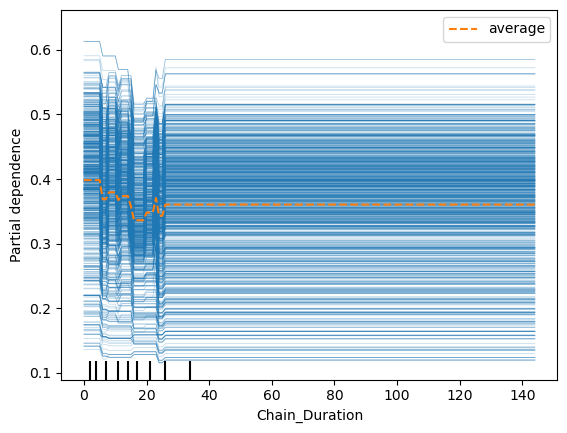

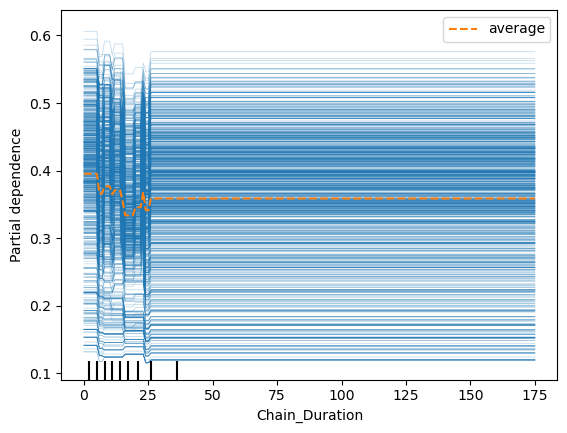

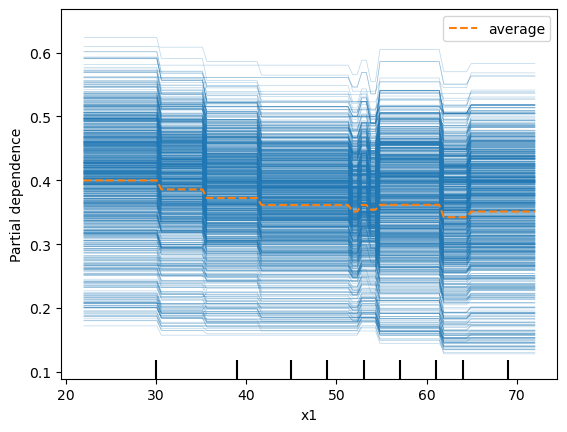

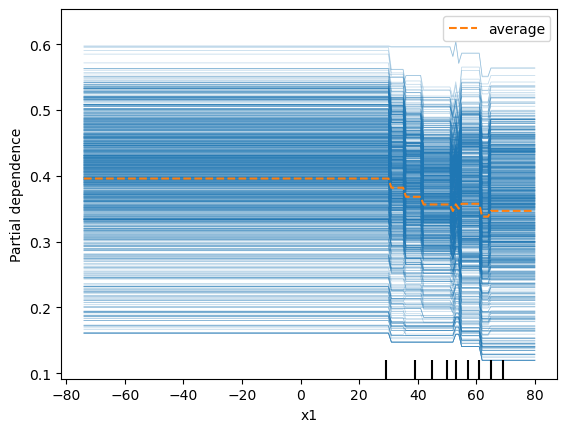

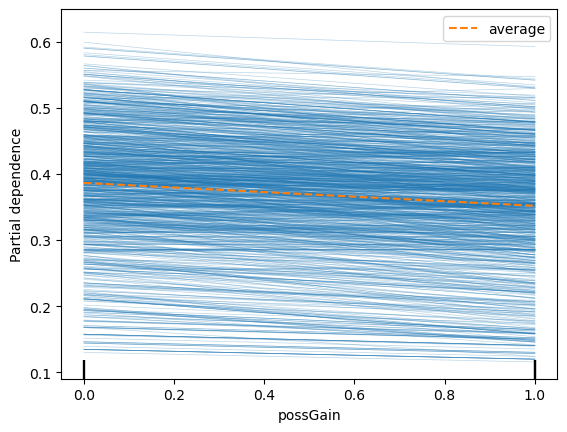

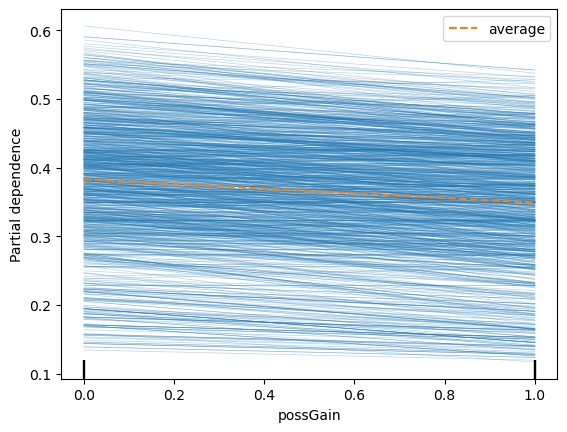

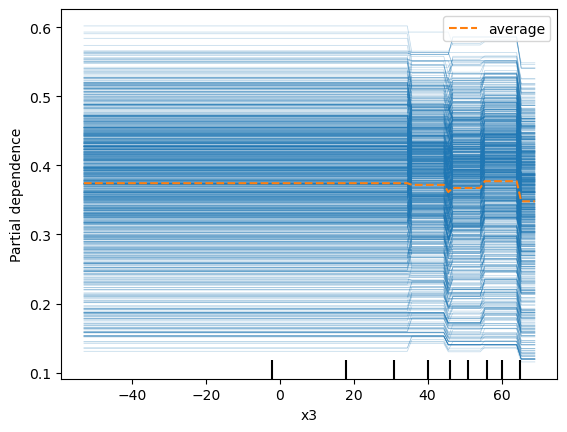

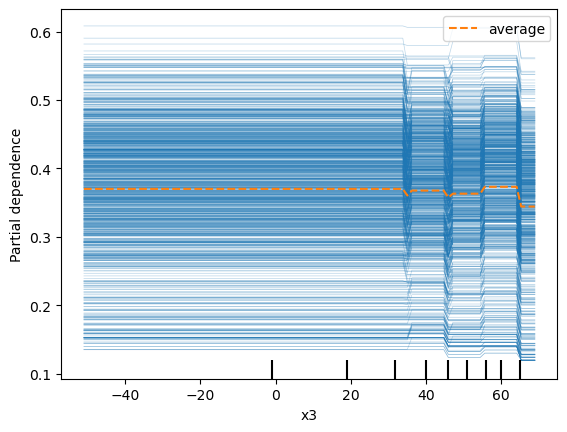

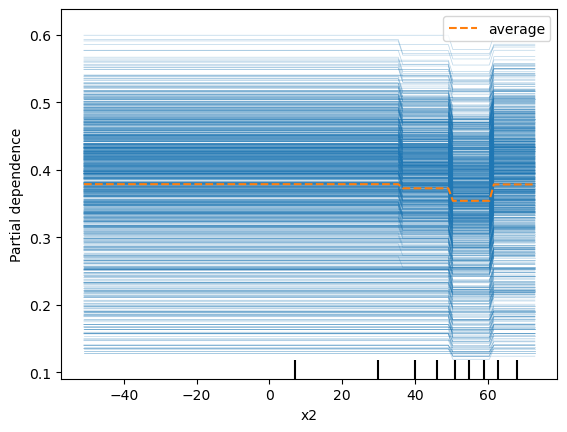

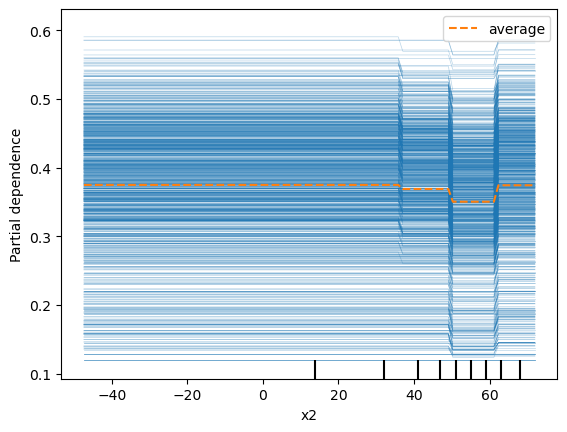

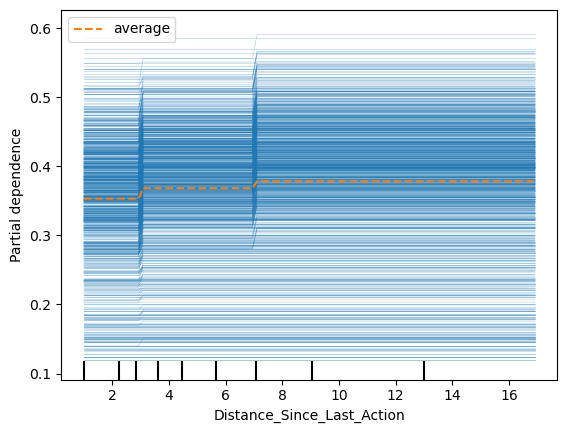

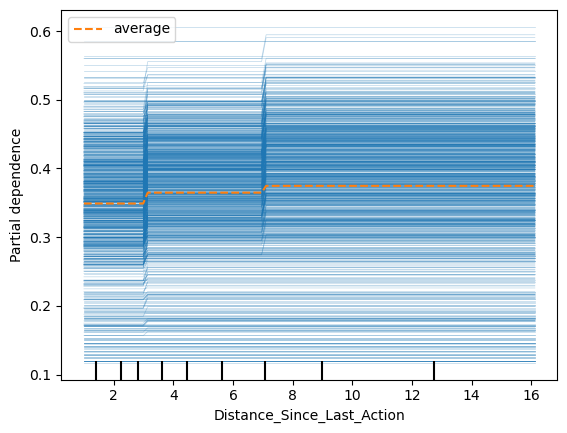

In [125]:
for col in top_10_features:
    train_xgb_evals.plot_ice([col])
    test_xgb_evals.plot_ice([col])

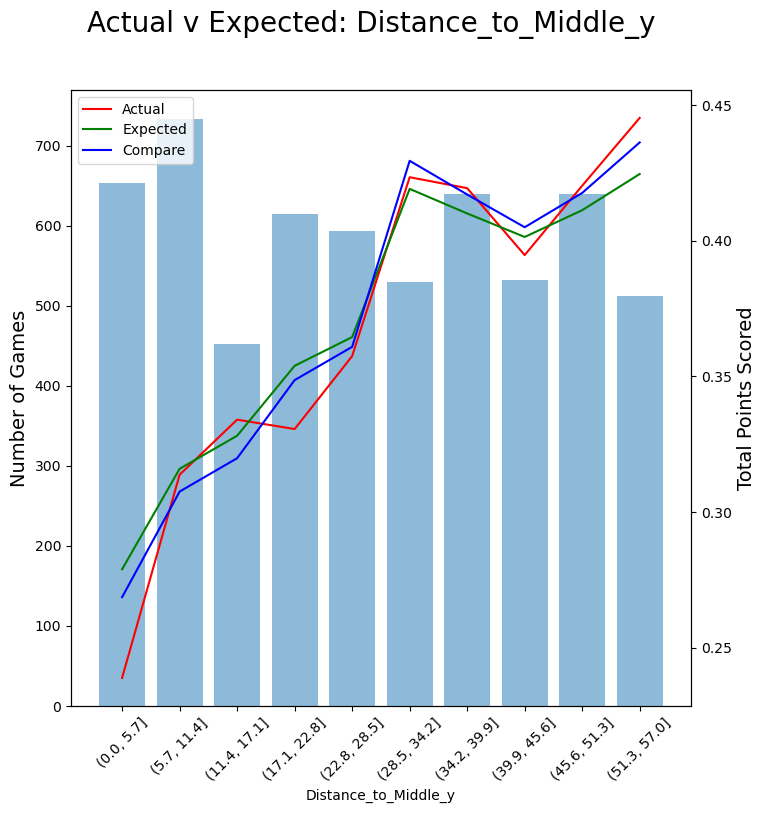

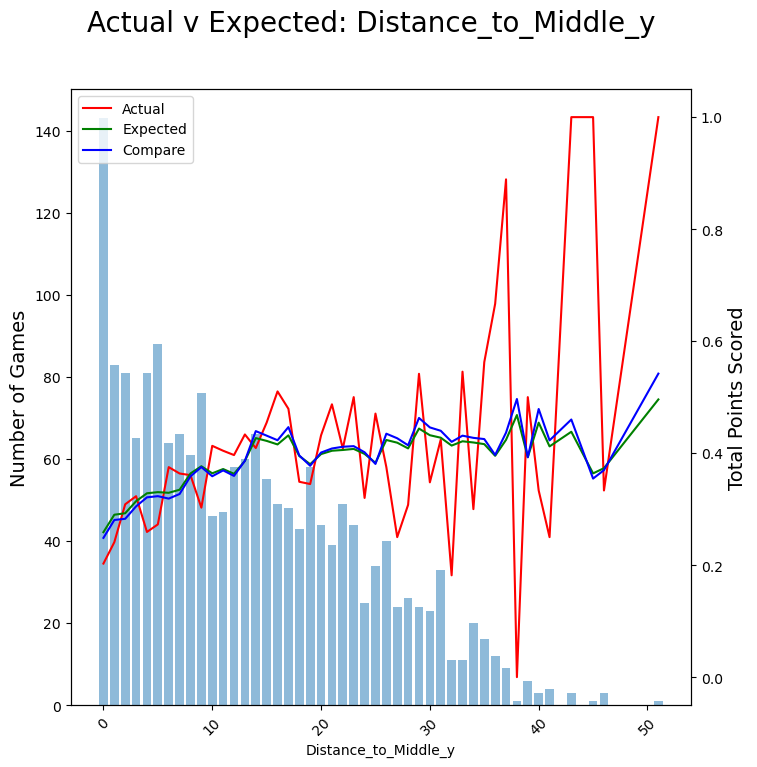

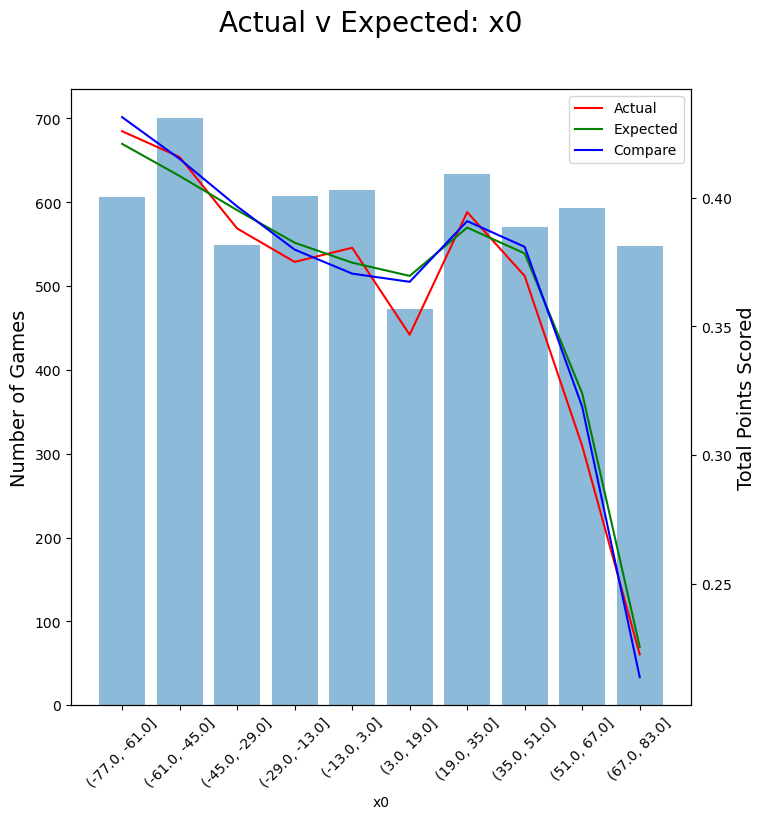

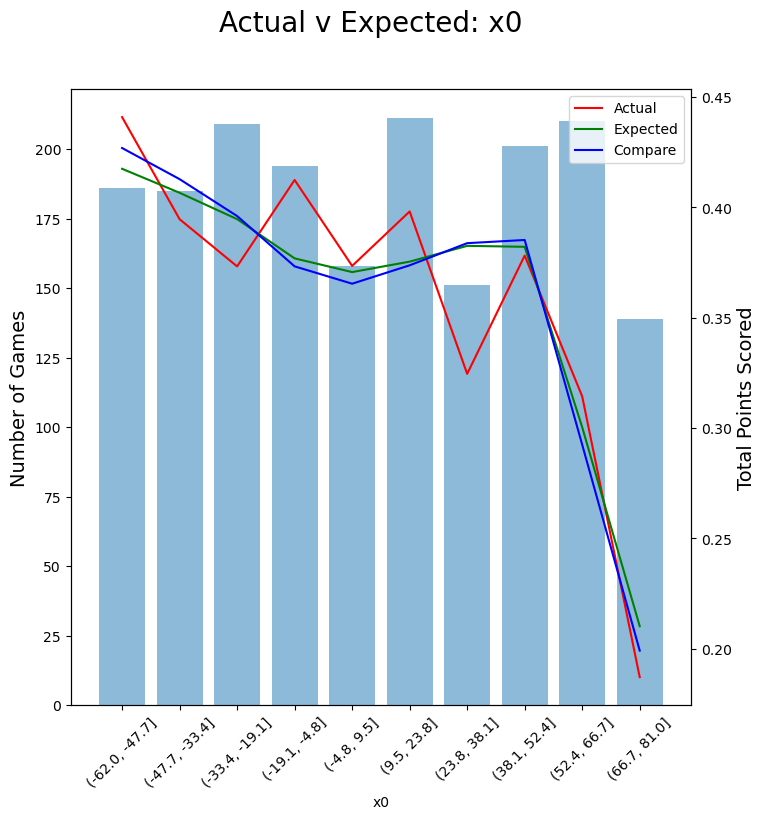

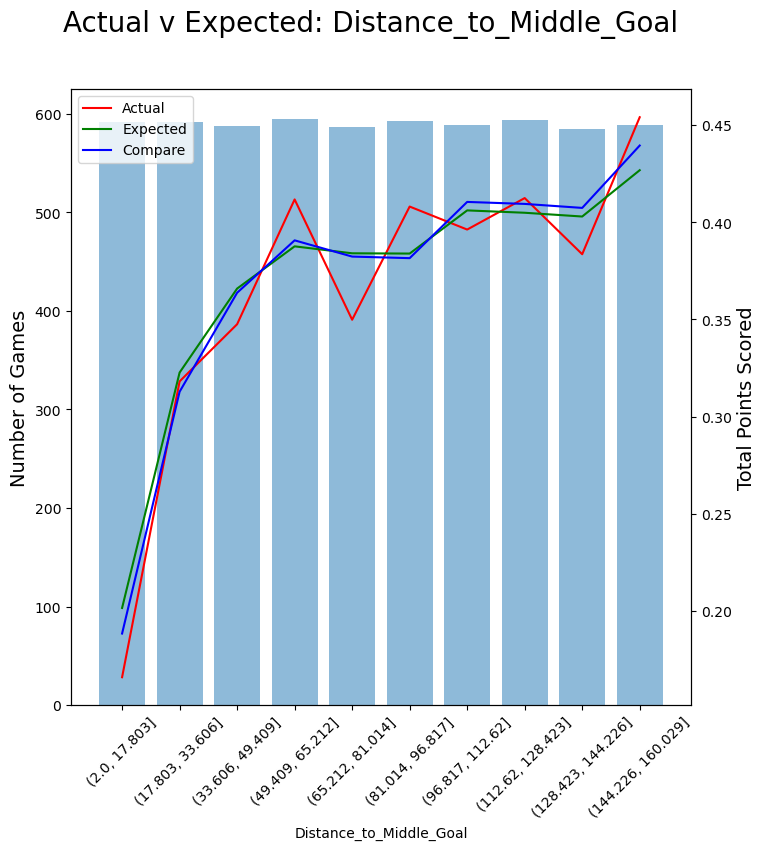

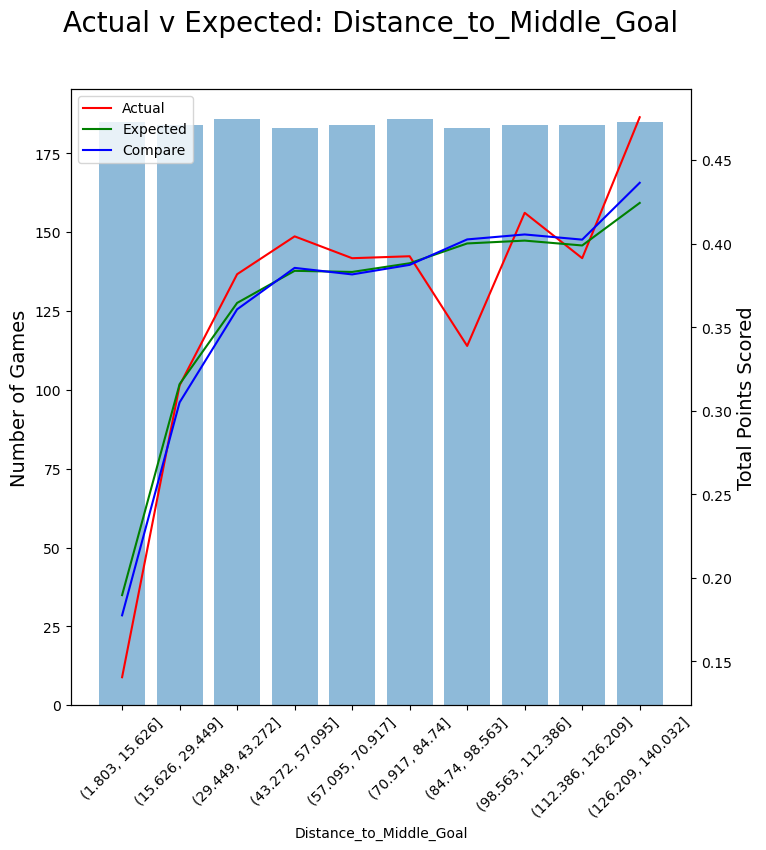

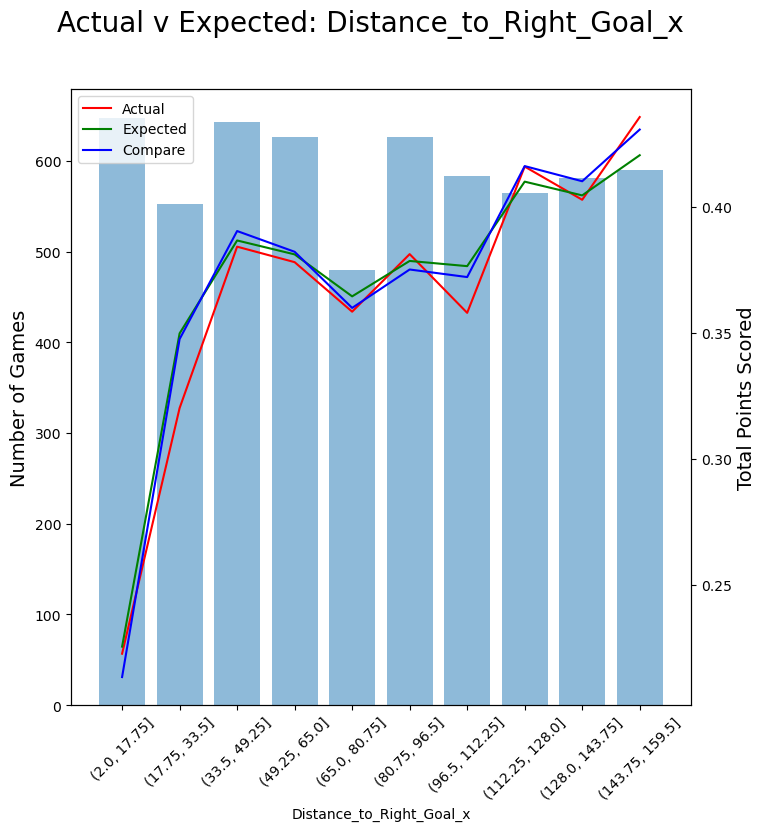

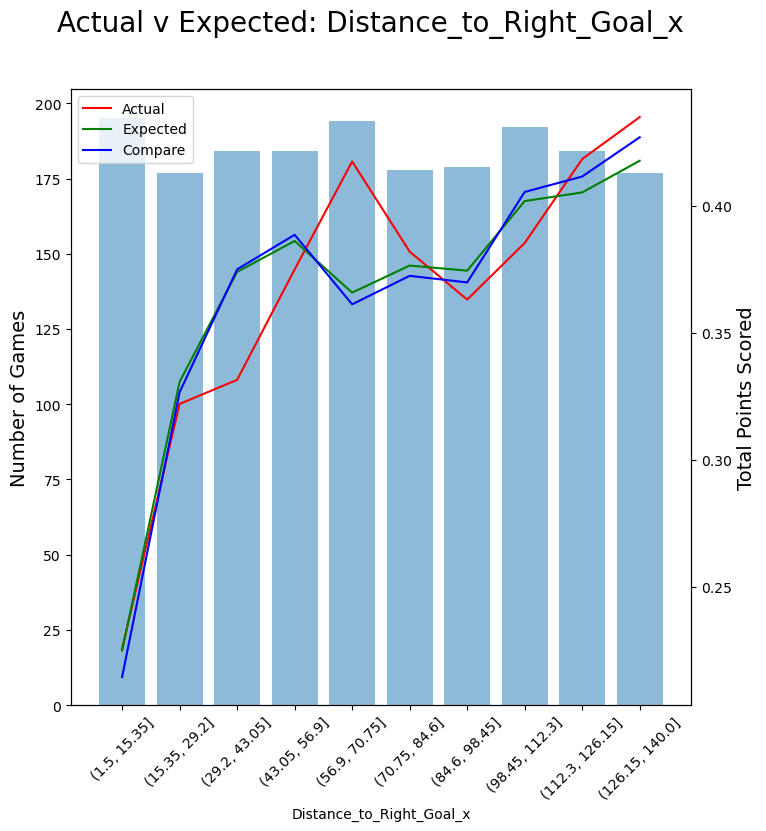

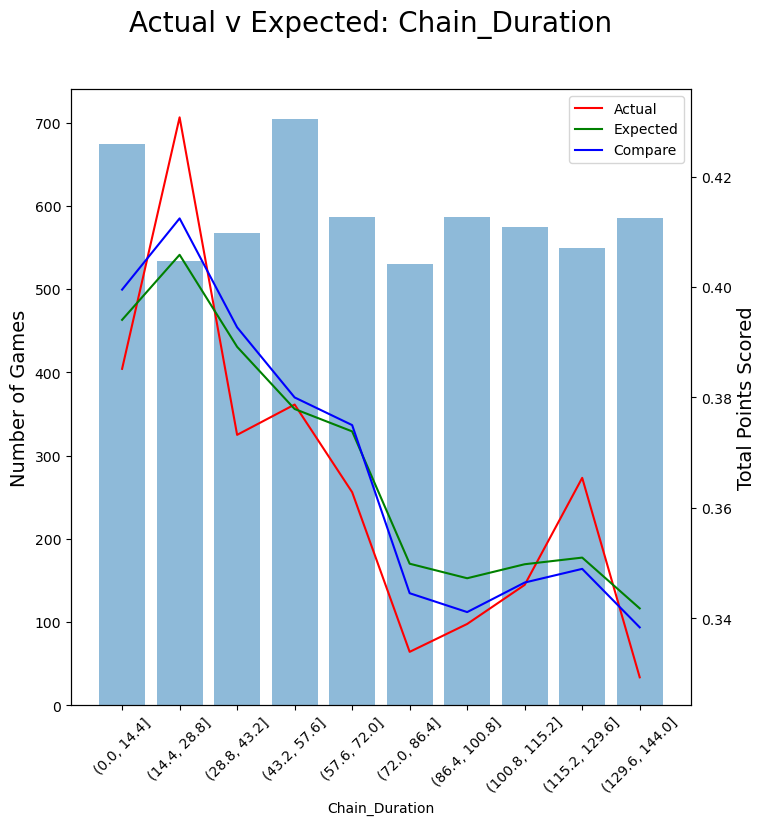

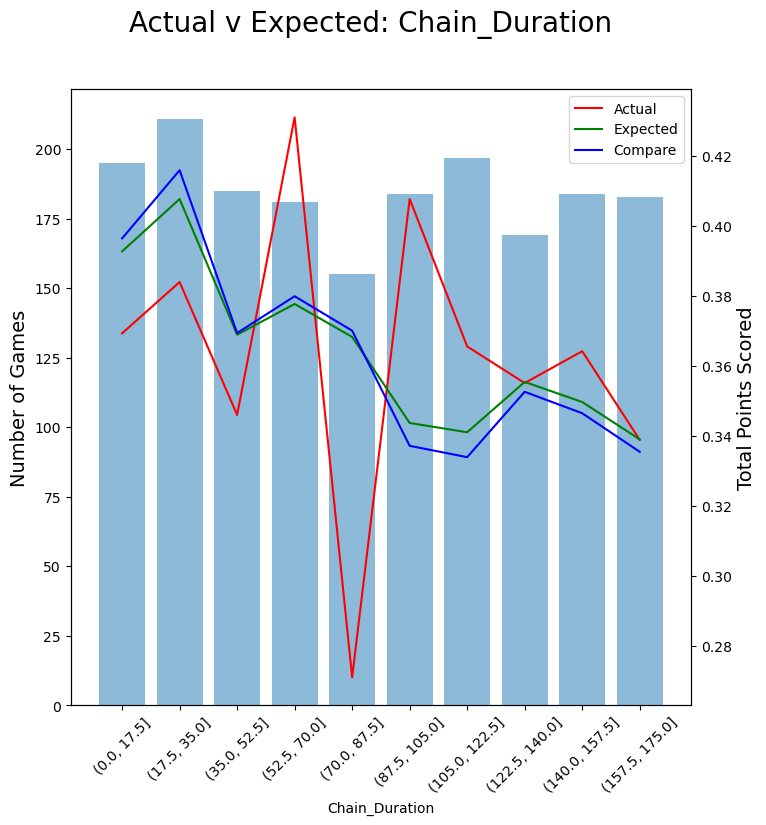

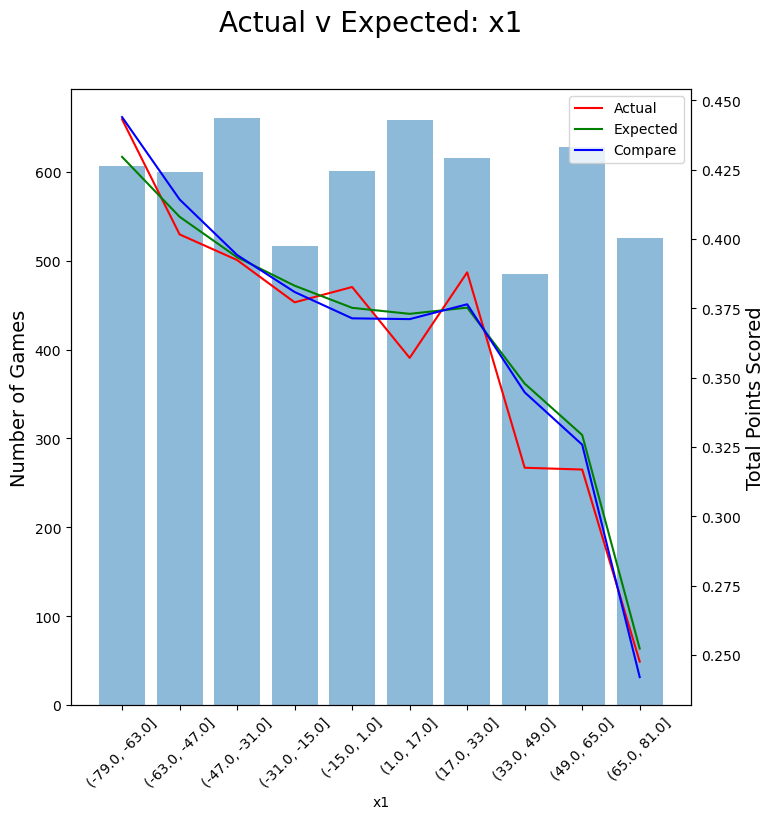

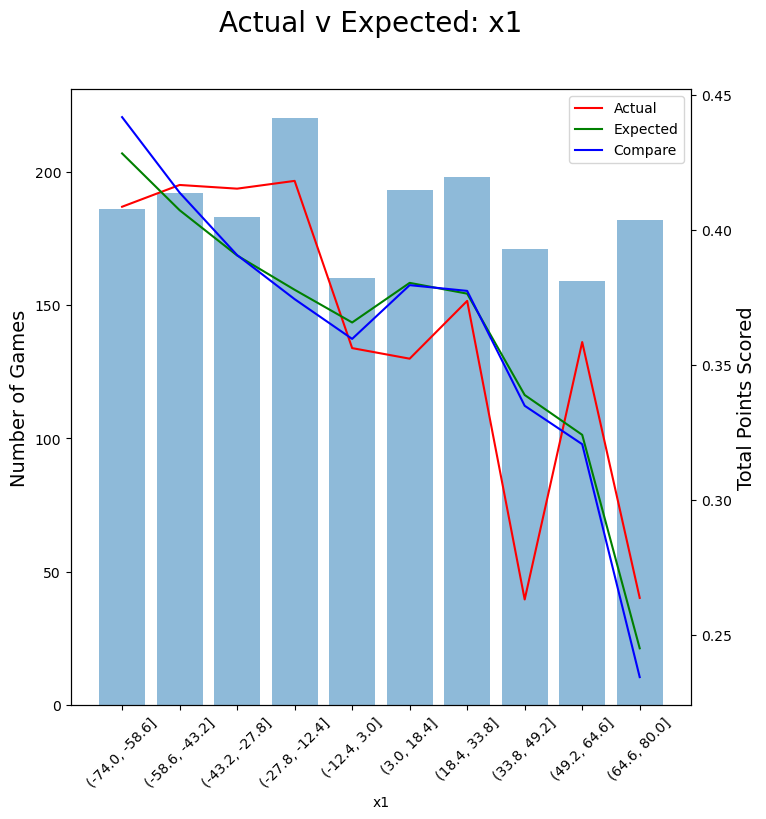

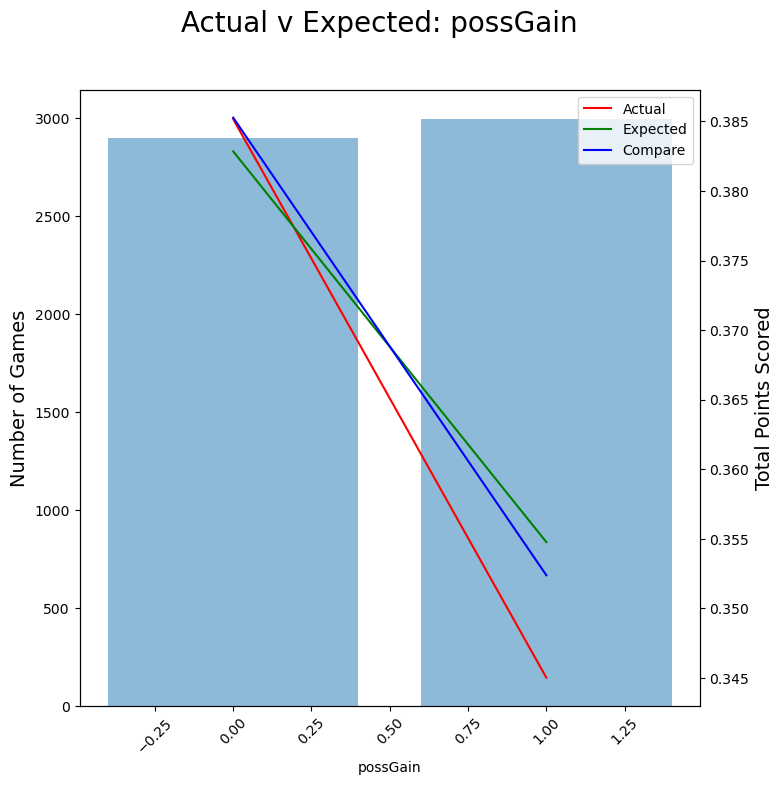

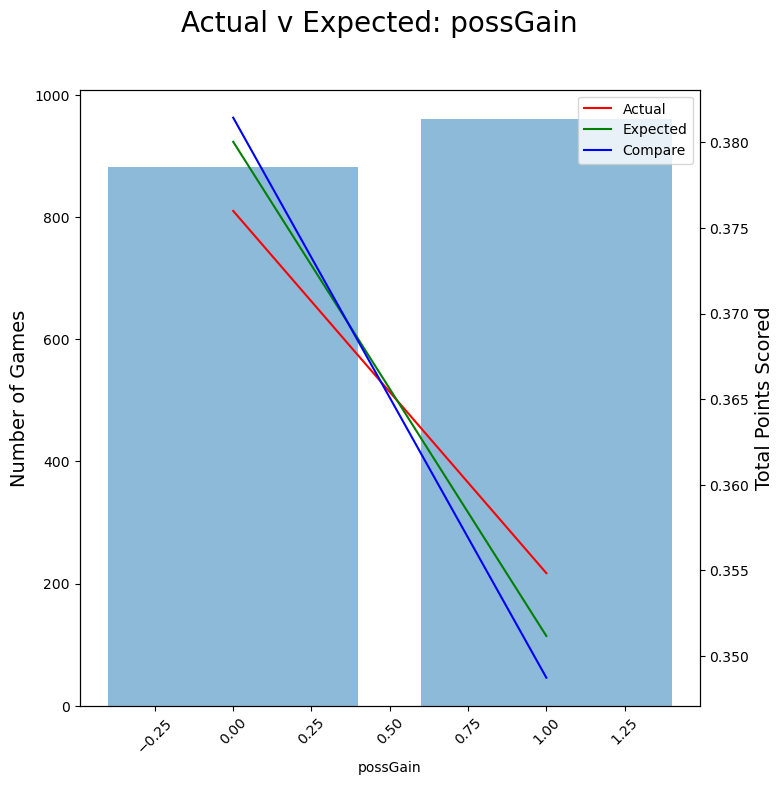

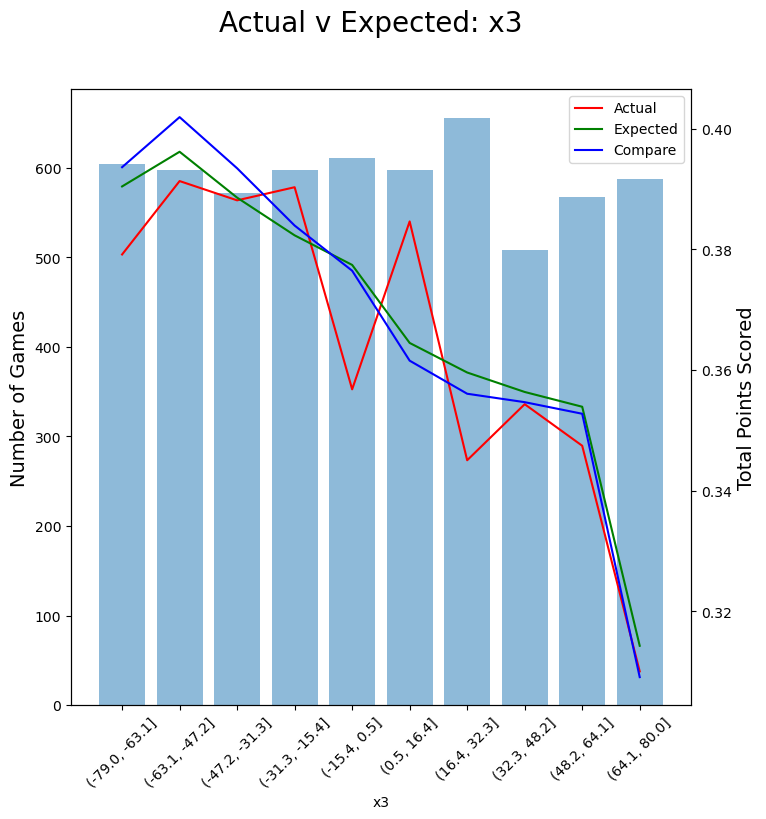

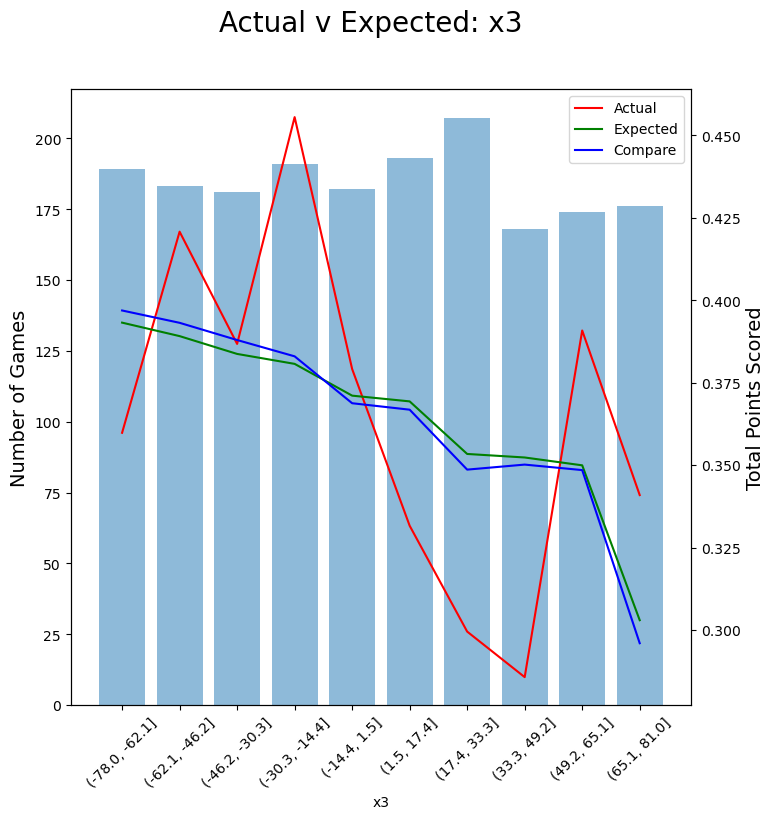

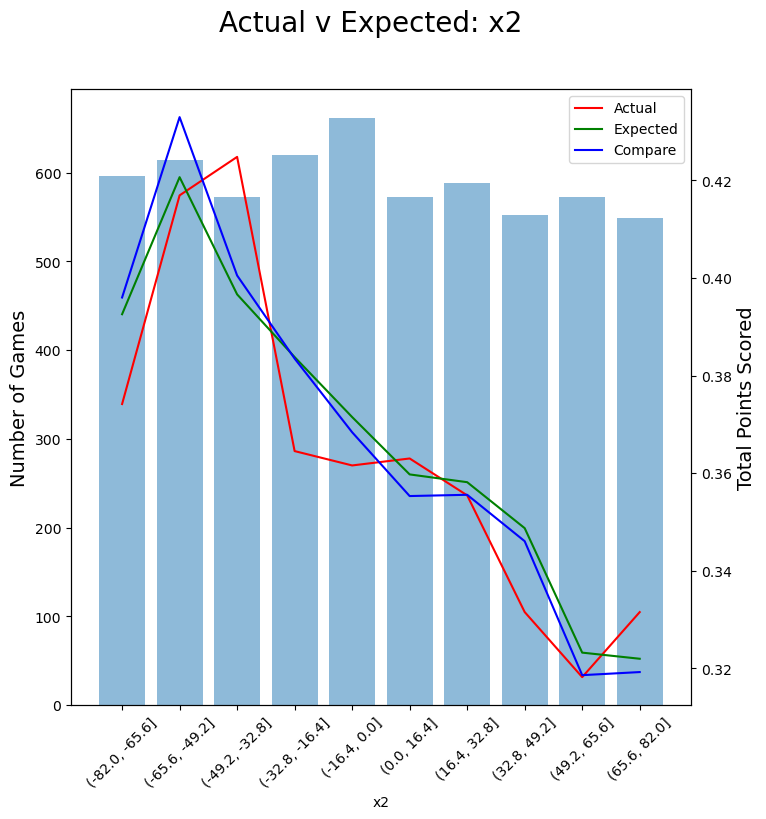

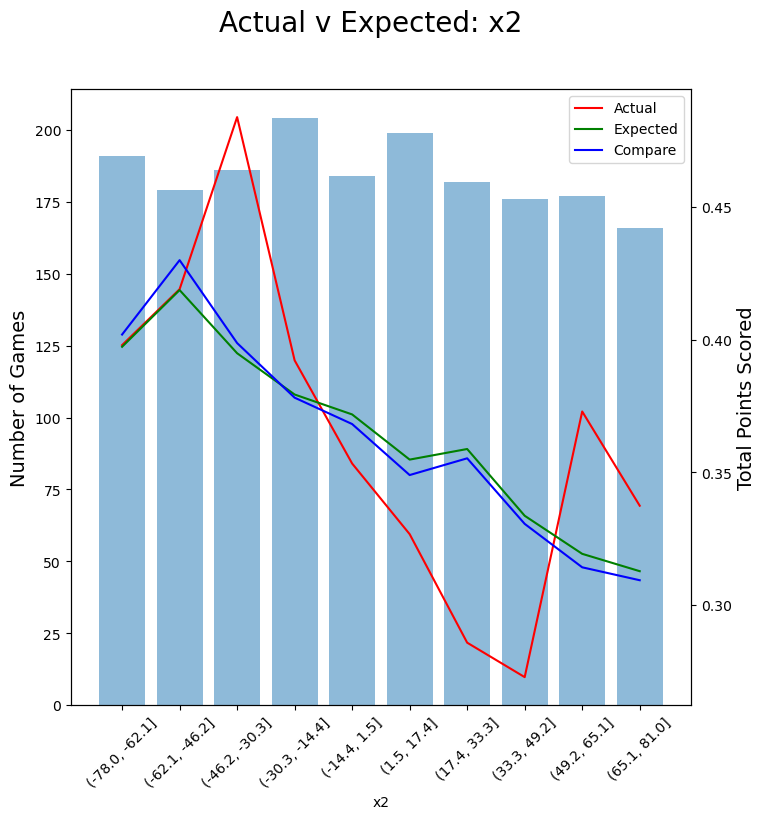

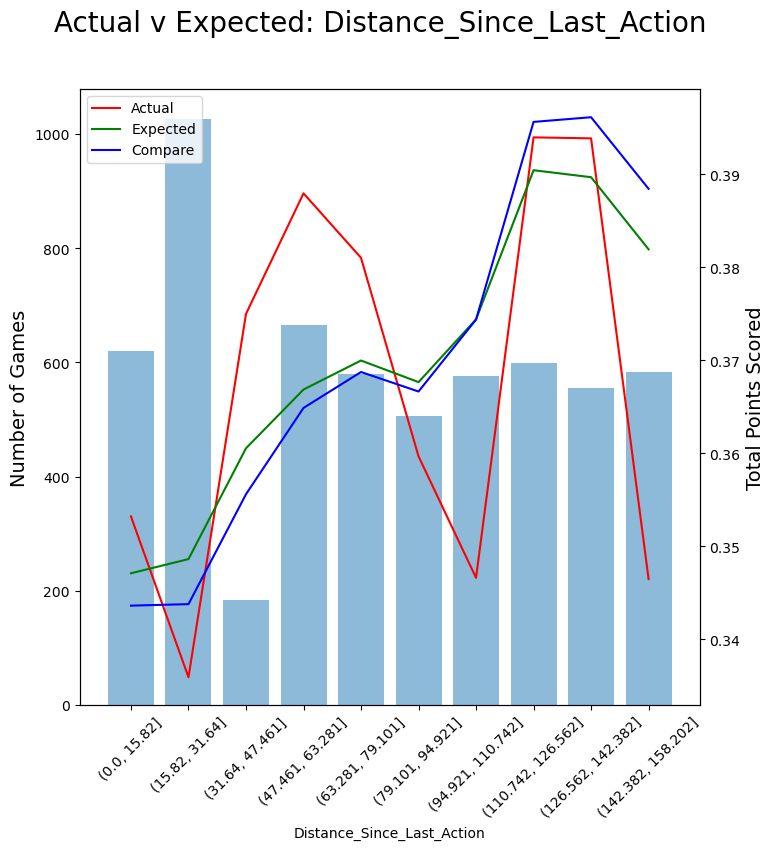

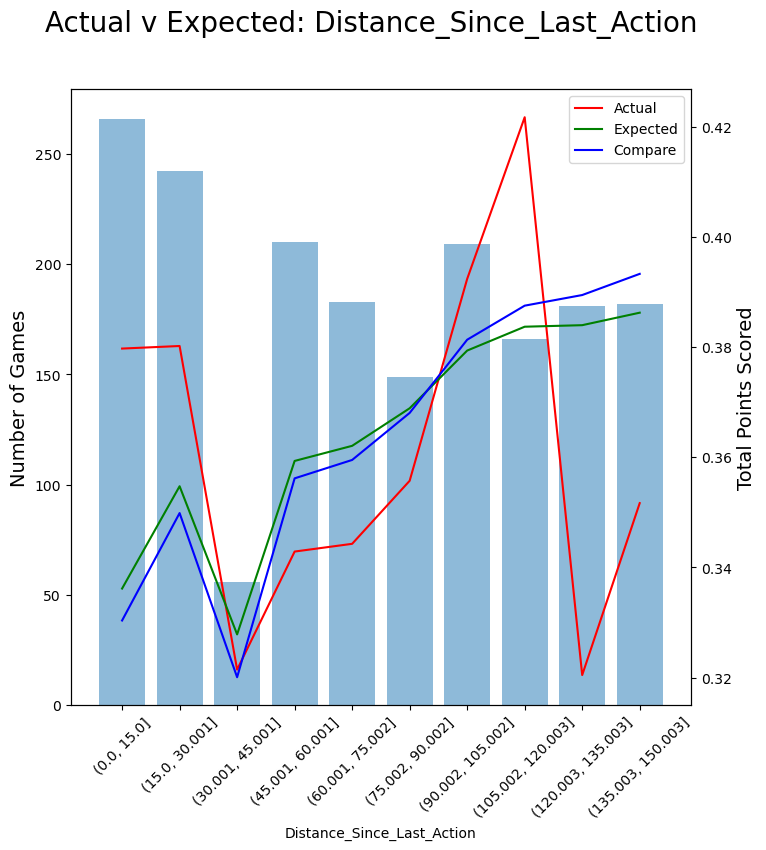

In [126]:
for col in top_10_features:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [127]:
train_xgb_evals.get_log_loss(), test_xgb_evals.get_log_loss()

Expected Log-Loss: 	0.6296
Compare Log-Loss: 	0.6275
Expected Log-Loss: 	0.6380
Compare Log-Loss: 	0.6392


((0.6295925117265522, 0.6295925117265522),
 (0.6380348511136835, 0.6380348511136835))

In [128]:
train_xgb_evals.get_brier_score_loss(), test_xgb_evals.get_brier_score_loss()

Expected Brier Score: 	0.2201
Compare Brier Score: 	0.2191
Expected Brier Score: 	0.2243
Compare Brier Score: 	0.2249


((0.22005059423645382, 0.21909261166810207),
 (0.2242921695967857, 0.22487817141486127))

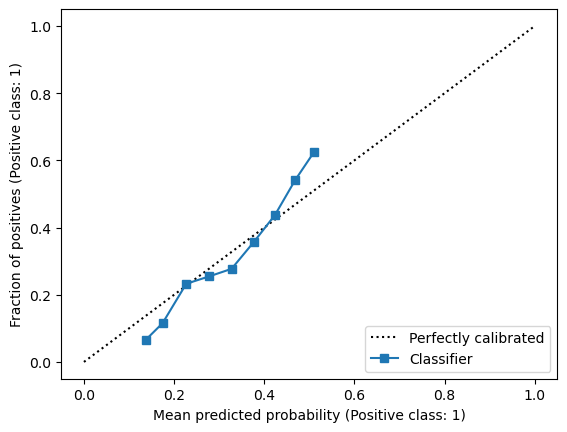

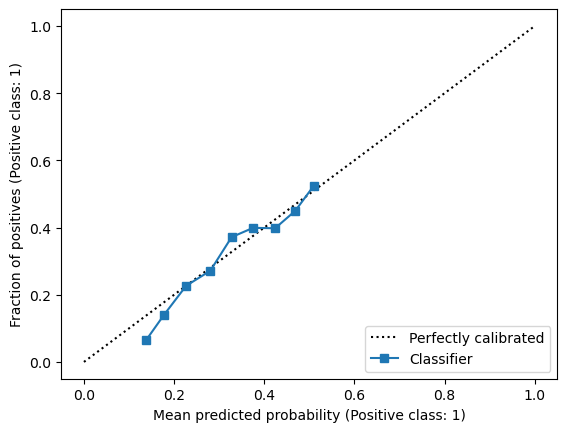

In [129]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)

Potential New Features

In [ ]:
# list(df_modelling)

In [ ]:
potential_feature_list = [
    'Initial_State',
    'x0',
    'x1',
    'x2',
    'x3',
    'y0',
    'y1',
    'y2',
    'y3',
    'Quarter_Duration0',
    'Chain_Duration',
    'Time_Since_Last_Action',
    'Distance_Since_Last_Action',
    'Distance_to_Right_Goal_x',
    'Distance_to_Middle_y',
    'Visible_Goal_Angle',
    'Visible_Behind_Angle',
    'Squared_Distance_to_Middle_Goal',
    'Log_Distance_to_Middle_Goal'
]

In [ ]:
for col in potential_feature_list:
    train_xgb_evals.plot_feature_ave(col)